Saving BookKOPEP.csv to BookKOPEP (17).csv
Estimated theta: 6.251738307795155e-06
Expected profit on January 31st: $0.76
5th percentile profit on January 31st: $-1,045.46
95th percentile profit on January 31st: $1,043.12

Expected profit on June 30th: $1.89
5th percentile profit on June 30th: $-2,566.08
95th percentile profit on June 30th: $2,549.70
Entry Upper Threshold: 31.70
Entry Lower Threshold: -94.06
Reasons: A significant deviation suggests a potential mean-reversion opportunity. Entering at these points increases the likelihood of profiting when the difference returns to its mean.
Exit Difference: -31.18
Reasons: Closing the position upon mean reversion locks in profits. It also reduces exposure to further market risk.


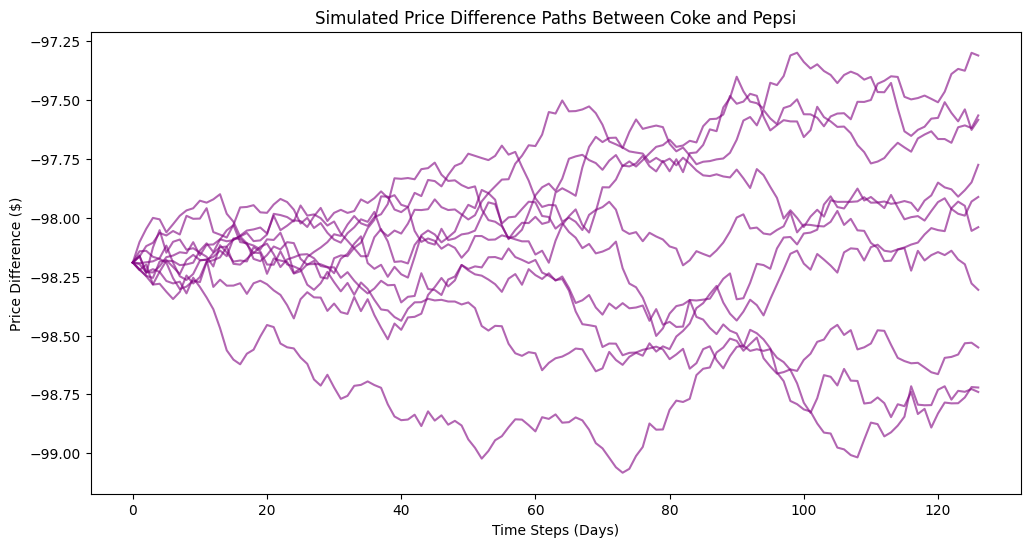

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load historical data
from google.colab import files
uploaded = files.upload()
import io
filename = next(iter(uploaded))
data = pd.read_csv(io.BytesIO(uploaded[filename]))

# Convert 'Date' column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Rename columns
data.rename(columns={'KO': 'Coke_Price', 'PEP': 'Pepsi_Price'}, inplace=True)

# Extract the closing prices
coke_prices = data['Coke_Price']
pepsi_prices = data['Pepsi_Price']

# Parameters
initial_investment = 100000
num_simulations = 1000000
time_horizon_days = 126
dt = 1 / 252

# Compute daily log returns
coke_returns = np.log(coke_prices / coke_prices.shift(1)).dropna()
pepsi_returns = np.log(pepsi_prices / pepsi_prices.shift(1)).dropna()

# Calculate price difference and its parameters
diff = coke_prices - pepsi_prices
diff = diff.dropna()
diff_returns = diff.diff().dropna()

# Estimate parameters
diff_mean = diff.mean()
diff_std = diff.std()

# Estimate theta using linear regression
from sklearn.linear_model import LinearRegression

diff_lag = diff.shift(1).dropna()
diff_diff = diff.diff().dropna()

# Align the data
diff_lag, diff_diff = diff_lag.align(diff_diff, join='inner')

X = diff_lag.values.reshape(-1, 1)
y = diff_diff.values

model = LinearRegression()
model.fit(X, y)
theta = -model.coef_[0]
print(f"Estimated theta: {theta}")

# Use daily volatility of the difference
sigma_diff = diff_returns.std()

# Initial difference
diff0 = diff.iloc[-1]

# Initial stock prices
S0_coke = coke_prices.iloc[-1]
S0_pepsi = pepsi_prices.iloc[-1]

# Number of shares to buy/short based on notional amount
num_coke_shares = initial_investment / S0_coke
num_pepsi_shares = initial_investment / S0_pepsi

# Simulate for the difference
def simulate_diff_paths(diff0, diff_mean, theta, sigma_diff, dt, N, M):
    diff_paths = np.zeros((M + 1, N))
    diff_paths[0] = diff0
    for t in range(1, M + 1):
        dW = np.random.normal(0, 1, N)  # Standard normal random variables
        diff_paths[t] = diff_paths[t - 1] + theta * (diff_mean - diff_paths[t - 1]) * dt + sigma_diff * np.sqrt(dt) * dW
    return diff_paths

# Simulate stock price paths based on difference paths
def simulate_stock_prices(S0_pepsi, pepsi_volatility, dt, N, M, diff_paths):
    # Preallocate arrays
    pepsi_paths = np.zeros((M + 1, N))
    coke_paths = np.zeros((M + 1, N))
    pepsi_paths[0] = S0_pepsi

    # Simulate Pepsi's price
    for t in range(1, M + 1):
        Z_pepsi = np.random.normal(0, 1, N)
        pepsi_paths[t] = pepsi_paths[t - 1] * np.exp(-0.5 * pepsi_volatility**2 * dt + pepsi_volatility * np.sqrt(dt) * Z_pepsi)
        # Coke's price derived from Pepsi's price and simulated difference
        coke_paths[t] = np.maximum(pepsi_paths[t] + diff_paths[t], 0.01)  # Ensure price is non-negative
    return coke_paths, pepsi_paths

# Number of time steps
M = time_horizon_days

# Simulate difference paths
diff_paths = simulate_diff_paths(diff0, diff_mean, theta, sigma_diff, dt, num_simulations, M)

# Simulate stock price paths
coke_paths, pepsi_paths = simulate_stock_prices(
    S0_pepsi=S0_pepsi,
    pepsi_volatility=pepsi_returns.std(),
    dt=dt,
    N=num_simulations,
    M=M,
    diff_paths=diff_paths
)

# Calculate profits/losses
def calculate_pl(coke_paths, pepsi_paths, num_coke_shares, num_pepsi_shares, days, S0_coke, S0_pepsi):
    # P&L for short position in KO
    coke_pl = (S0_coke - coke_paths[days]) * num_coke_shares
    # P&L for long position in PEP
    pepsi_pl = (pepsi_paths[days] - S0_pepsi) * num_pepsi_shares
    # Total P&L
    total_pl = coke_pl + pepsi_pl
    return total_pl

# Days corresponding to January 31st and June 30th
jan_31_days = int(21)
jun_30_days = M

# P&L on January 31st and June 30th
# P&L on January 31st and June 30th
pl_jan_31 = calculate_pl(
    coke_paths, pepsi_paths, num_coke_shares, num_pepsi_shares, jan_31_days, S0_coke, S0_pepsi
)
pl_jun_30 = calculate_pl(
    coke_paths, pepsi_paths, num_coke_shares, num_pepsi_shares, jun_30_days, S0_coke, S0_pepsi
)

# Expected values and percentiles
def calculate_statistics(pl_array):
    expected_value = np.mean(pl_array)
    percentile_5 = np.percentile(pl_array, 5)
    percentile_95 = np.percentile(pl_array, 95)
    return expected_value, percentile_5, percentile_95

expected_jan_31, percentile_5_jan_31, percentile_95_jan_31 = calculate_statistics(pl_jan_31)
expected_jun_30, percentile_5_jun_30, percentile_95_jun_30 = calculate_statistics(pl_jun_30)

# Entry price and exit price
entry_upper = diff_mean + 2 * diff_std
entry_lower = diff_mean - 2 * diff_std
exit_diff = diff_mean

# Output the results
print(f"Expected profit on January 31st: ${expected_jan_31:,.2f}")
print(f"5th percentile profit on January 31st: ${percentile_5_jan_31:,.2f}")
print(f"95th percentile profit on January 31st: ${percentile_95_jan_31:,.2f}\n")

print(f"Expected profit on June 30th: ${expected_jun_30:,.2f}")
print(f"5th percentile profit on June 30th: ${percentile_5_jun_30:,.2f}")
print(f"95th percentile profit on June 30th: ${percentile_95_jun_30:,.2f}")

print(f"Entry Upper Threshold: {entry_upper:.2f}")
print(f"Entry Lower Threshold: {entry_lower:.2f}")
print("Reasons: A significant deviation suggests a potential mean-reversion opportunity. Entering at these points increases the likelihood of profiting when the difference returns to its mean.")
print(f"Exit Difference: {exit_diff:.2f}")
print("Reasons: Closing the position upon mean reversion locks in profits. It also reduces exposure to further market risk.")

# Plotting a few simulated difference paths for illustration
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(diff_paths[:, i], color='purple', alpha=0.6)
plt.title('Simulated Price Difference Paths Between Coke and Pepsi')
plt.xlabel('Time Steps (Days)')
plt.ylabel('Price Difference ($)')
plt.show()